# We work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

## We are going to carry out a preliminary analysis of the plans based on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. <br>We will analyze clients' behavior and determine which prepaid plan brings in more revenue.

### Tables Of Contents <a class="anchor" id="table_of_contents"></a>

* [Prepare The Data](#chapter1)
    * [Import Libraries](#section_1_1)
    * [Open data file](#section_1_2)
    * [Overview](#section_1_3)
    * [Dealing with missing values](#section_1_4)
    * [Convert dtypes](#section_1_5)
    * [For each user - find call duration, # of sms and data usage per month](#section_1_6)
    * [Calculate Revenue from each user](#section_1_7)
    
* [Data Analysis](#chapter2)
    * [Central tendency of usage](#section_2_1)
    * [Test the hypothese](#section_2_2)

* [Overall conclusion](#chapter3)


## Prepare The Data: <a class="anchor" id="chapter1">

### Import libraries:<a class="anchor" id="section_1_1">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats as st
import seaborn as sns
from scipy.stats import mannwhitneyu

### Open data files: <a class="anchor" id="section_1_2">

In [2]:
try:
    df_users = pd.read_csv('C:/Users/priel/Downloads/megaline_users.csv')
    df_calls = pd.read_csv('C:/Users/priel/Downloads/megaline_calls.csv')
    df_data = pd.read_csv('C:/Users/priel/Downloads/megaline_internet.csv')
    df_sms = pd.read_csv('C:/Users/priel/Downloads/megaline_messages.csv')    
    df_plans = pd.read_csv('C:/Users/priel/Downloads/megaline_plans.csv')
    
except: 
    df_users = pd.read_csv('/datasets/megaline_users.csv')
    df_calls= pd.read_csv('/datasets/megaline_calls.csv')
    df_data = pd.read_csv('/datasets/megaline_internet.csv')
    df_sms = pd.read_csv('/datasets/megaline_messages.csv')
    df_plans = pd.read_csv('/datasets/megaline_plans.csv')

#### [Go back to the Table of Contents](#table_of_contents)

### Overview: <a class="anchor" id="section_1_3">

#### Starting with df_users:

In [3]:
df_users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
425,1425,Latrisha,Larsen,19,"Las Vegas-Henderson-Paradise, NV MSA",2018-09-20,surf,NaN
64,1064,Gerardo,Ashley,46,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-03,surf,NaN
152,1152,Merrill,Hogan,35,"Orlando-Kissimmee-Sanford, FL MSA",2018-11-01,surf,NaN
333,1333,Macy,David,57,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-11-24,ultimate,NaN
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18


In [4]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
df_users.isna().sum()/len(df_users)

user_id       0.000
first_name    0.000
last_name     0.000
age           0.000
city          0.000
reg_date      0.000
plan          0.000
churn_date    0.932
dtype: float64

###### Errors found in df_users:
* reg_date and churn_date are object, and should be datetime.
* churn_date have 466 missing values**(93%)**, meaning that 34 users have stopped the service on a given date.
* first name and last name are two columns, we can consider joining them togather.(or drop them, since we dont need them for analysis)

#### Moving to df_calls:

In [6]:
df_calls.sample(5)

,id,user_id,call_date,duration
79824,1285_352,1285,2018-12-16,8.00
12957,1056_100,1056,2018-12-18,2.86
9900,1044_174,1044,2018-10-13,12.79
424,1003_34,1003,2018-12-27,0.00
77996,1279_124,1279,2018-11-10,7.14


In [7]:
df_calls['id'].duplicated().sum()

0

In [8]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


##### Errors found in df_calls:
* call_date is object, should be datetime.

#### Moving to df_data:

In [9]:
df_data.sample(5)

,id,user_id,session_date,mb_used
39830,1179_161,1179,2018-10-22,245.20
71289,1332_262,1332,2018-09-23,97.43
11073,1055_78,1055,2018-08-05,377.59
50878,1227_40,1227,2018-12-24,555.30
12988,1061_485,1061,2018-10-23,88.23


In [10]:
df_data['id'].duplicated().sum()

0

In [11]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


##### Error found in df_data:
* session_date is object, should be datetime.

#### Moving to df_sms:

In [12]:
df_sms.sample(5)

,id,user_id,message_date
2523,1028_442,1028,2018-11-17
44937,1302_42,1302,2018-09-29
52860,1337_104,1337,2018-12-28
74634,1482_47,1482,2018-11-04
72780,1470_408,1470,2018-07-15


In [13]:
df_sms['id'].duplicated().sum()

0

In [14]:
df_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


##### Error found in df_sms:
* message_date is object, should be datetime.

#### Moving to df_plans:

In [15]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [16]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


##### No errors found in df_plans.

#### Errors found through out our data sets:
* number of columns to convert dtypes - object -> datetime:
   * reg_date and churn_date from df_users
   * call_date from df_calls
   * session_date from df_data
   * message_date from df_sms
* churn_date has more than 93% missing values (**MNAR**). column description is - the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)

#### [Go back to the Table of Contents](#table_of_contents)  

### Dealing with missing values: <a class="anchor" id="section_1_4">

##### Since missing values in the churn_date column means that the user have not stopped the service when the data was collected, it means that the proper value to fill the NaN is with the date of the end of 2018.

In [17]:
df_users['churn_date'].fillna(value= '2018-12-31', inplace=True)

In [18]:
#checking
df_users['churn_date'].value_counts()

2018-12-31    468
2018-12-18      3
2018-11-14      2
2018-12-19      2
2018-12-22      1
2018-12-30      1
2018-11-16      1
2018-11-30      1
2018-09-17      1
2018-10-03      1
2018-11-11      1
2018-10-13      1
2018-09-18      1
2018-08-16      1
2018-11-21      1
2018-12-27      1
2018-10-22      1
2018-12-12      1
2018-09-07      1
2018-11-29      1
2018-12-15      1
2018-08-19      1
2018-12-10      1
2018-11-24      1
2018-11-18      1
2018-12-26      1
2018-07-31      1
2018-09-01      1
2018-10-07      1
Name: churn_date, dtype: int64

#### [Go back to the Table of Contents](#table_of_contents)  

### Convert data types <a class="anchor" id="section_1_5">

In [19]:
# convert reg_date to datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

In [20]:
# convert churn_date to datetime
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

In [21]:
#checking
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    500 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [22]:
# convert call_date to datetime
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

In [23]:
#checking
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [24]:
# convert session_date to datetime
df_data['session_date'] = pd.to_datetime(df_data['session_date'])

In [25]:
#checking
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [26]:
# convert message_date to datetime
df_sms['message_date'] = pd.to_datetime(df_sms['message_date'])

In [27]:
#checking
df_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


#### [Go back to the Table of Contents](#table_of_contents)  

### For each user - we will find # of calls & minutes, sms, data usage and revenue: <a class="anchor" id="section_1_6">

#### The Logical process for this task is as follow:
##### Construct new columns to df_users of days_used and months_used which will give us the number of days a user is using the service.
##### Extract the month for every useage date and construct a month column for each dataset, this will help find the monthly usage per user
##### Round the minutes of individual calls made upwards (because that's how Megaline calculates minutes)
##### Sum the usage of each service by month.
##### Round data usage upwards each month:
* For calls we will sum the rounded number of minutes 
* For sms we will count the number of sms sent each month per user
* For internet usage we will sum the amount of mb used per month, than we will round it up by GB(just as Megaline do)

In [28]:
# construct new days_used column in df_users
df_users['days_used'] = (df_users['churn_date'] - df_users['reg_date']).dt.days

In [29]:
#checking
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,7
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,140
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2018-12-31,71
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2018-12-31,337
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2018-12-31,222


In [30]:
# construct months_used out of days_used
df_users['months_used'] = df_users['days_used']/30

In [31]:
#checking
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_used,months_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,7,0.233333
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,140,4.666667
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2018-12-31,71,2.366667
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2018-12-31,337,11.233333
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2018-12-31,222,7.400000


In [32]:
len(df_users.loc[df_users['months_used']<1])

36

**We have 36 users that used the service for less than one month, we can consider dropping those rows.**

##### Construct new columns of month for each dataset to help find the monthly usage:

In [33]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month

In [34]:
df_sms['month'] = pd.DatetimeIndex(df_sms['message_date']).month

In [35]:
df_data['month'] = pd.DatetimeIndex(df_data['session_date']).month

In [36]:
#checking
df_calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


In [37]:
#checking
df_sms.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [38]:
#checking
df_data.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


#### Next, rounding individual calls duration up (just as Megaline do):

In [39]:
df_calls['duration'] = np.ceil(df_calls['duration'])

In [40]:
#checking
df_calls['duration'].value_counts()

0.0     26834
6.0      7848
5.0      7778
7.0      7769
8.0      7718
4.0      7434
9.0      7357
3.0      6942
10.0     6918
2.0      6446
11.0     6407
1.0      5795
12.0     5750
13.0     5070
14.0     4402
15.0     3889
16.0     3011
17.0     2461
18.0     1992
19.0     1604
20.0     1243
21.0      910
22.0      671
23.0      461
24.0      324
25.0      235
26.0      157
27.0      118
28.0       62
29.0       58
30.0       27
31.0       18
32.0       13
33.0        6
36.0        3
34.0        2
38.0        1
37.0        1
Name: duration, dtype: int64

**We have a lot of zeros in duration and mb_used columns. let's check their portion and try to find out why this has happaned**

In [41]:
#using count() method to check number of zero in the column
display('Number of zeros in duration column, in the calls table:')
display(df_calls[df_calls['duration']==0]['id'].count())

'Number of zeros in duration column, in the calls table:'

26834

In [42]:
#using count() method to check number of zero in the column
display('Number of zeros in mb_used column, in the data table:')
display(df_data[df_data['mb_used']==0]['id'].count())

'Number of zeros in mb_used column, in the data table:'

13747

**Let's check their portion in the column**

In [43]:
#using count() and len() method to check portion of zero in the column
display('Portion of zeros in duration column, in the calls table:')
display('{:.1%}'.format(df_calls[df_calls['duration']==0]['id'].count()/len(df_calls)))

'Portion of zeros in duration column, in the calls table:'

'19.5%'

In [44]:
#using count() and len() method to check portion of zero in the column
display('Portion of zeros in mb_used column, in the data table:')
display('{:.1%}'.format(df_data[df_data['mb_used']==0]['id'].count()/len(df_data)))

'Portion of zeros in mb_used column, in the data table:'

'13.1%'

OK, the numbers are pretty high, though it still is possible that 19.5% of calls will be missed and therefor will be zero seconds. it is also possible that users sometimes dont consume data.
<br>let's check how many users have zero in the duration and mb_used column.

In [45]:
display('Number of users with zero in the duration column:',
        (df_calls[df_calls['duration']==0]['user_id'].value_counts().count()))

'Number of users with zero in the duration column:'

478

In [46]:
display('Number of users with zero in the mb_used column:',
        (df_data[df_data['mb_used']==0]['user_id'].value_counts().count()))

'Number of users with zero in the mb_used column:'

477

**So, we found out that most users have entries with 0 in the duration and mb_used columns, not that weird.
how will it affect the result of the precessing and the analysis?
we are going to sum all the calls a user made in a month, so a zero value won't change anything in the precess, i think we can continue**

##### Next I'll find the usage units number per user, starting with calls made - using .pivot_table function:

In [47]:
#creating pivot table grouping the duration by user_id and month, aggfunc count and sum to get number of calls and duration:
df_calls_per_user = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()

In [48]:
#changing columns name
df_calls_per_user.columns = ['user_id', 'month', 'num_calls', 'duration']

##### The table below shows us the total duration of calls each month after rounding up each call, for each user:

In [49]:
df_calls_per_user

,user_id,month,num_calls,duration
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0
...,...,...,...,...
2253,1498,12,39,339.0
2254,1499,9,41,346.0
2255,1499,10,53,385.0
2256,1499,11,45,308.0


##### Moving on to number of messages sent by each user:

In [50]:
# Grouping sms_sent by user_id and month:
df_sms_per_user = df_sms.groupby(['user_id', 'month'])['id'].count()

In [51]:
# Turning the series to dataframe:
df_sms_per_user = df_sms_per_user.to_frame()

In [52]:
# changing column name from id to sms_sent:
df_sms_per_user.columns = ['sms_sent']

##### The table below shows the number of sms sent for each user:

In [53]:
df_sms_per_user

sms_sent
user_id month          
1000    12           11
1001    8            30
        9            44
        10           53
        11           36
...                 ...
1496    9            21
        10           18
        11           13
        12           11
1497    12           50

[1806 rows x 1 columns]

##### Moving to internet usage per user:

**Reminder - Megaline rounds up usage at the end of the month**

In [54]:
# Grouping mb_used by user_id and month:
df_data_per_user = df_data.groupby(['user_id', 'month'])['mb_used'].sum()

In [55]:
# Turning series to dataframe:
df_data_per_user = df_data_per_user.to_frame()

In [56]:
#Constructing new column of GB_used:
df_data_per_user['GB_used'] = df_data_per_user['mb_used'] / 1024

In [57]:
#Rounding each month's GB usage upwards:
df_data_per_user['GB_used'] = np.ceil(df_data_per_user['GB_used'])

##### The table below shows the usage of data for each user per month:

In [58]:
df_data_per_user

mb_used  GB_used
user_id month                   
1000    12      1901.47      2.0
1001    8       6919.15      7.0
        9      13314.82     14.0
        10     22330.49     22.0
        11     18504.30     19.0
...                 ...      ...
1498    12     23137.69     23.0
1499    9      12984.76     13.0
        10     19492.43     20.0
        11     16813.83     17.0
        12     22059.21     22.0

[2277 rows x 2 columns]

##### Now that we have the duration of calls made, sms sent and data used by each user,  lets combine this information to one table.
##### Before i start merging i want to make sure i dont have any unnecesary columns.

In [59]:
df_calls_per_user.head()

,user_id,month,num_calls,duration
0,1000,12,16,124.0
1,1001,8,27,182.0
2,1001,9,49,315.0
3,1001,10,65,393.0
4,1001,11,64,426.0


No unnecesary columns here

In [60]:
df_sms_per_user.head()

sms_sent
user_id month          
1000    12           11
1001    8            30
        9            44
        10           53
        11           36

No unnecesary columns here too

In [61]:
df_data_per_user.head()

mb_used  GB_used
user_id month                   
1000    12      1901.47      2.0
1001    8       6919.15      7.0
        9      13314.82     14.0
        10     22330.49     22.0
        11     18504.30     19.0

I dont need the mb_used column since we are calculating revenue from the rounded GB, i will drop the column now.

In [62]:
df_data_per_user = df_data_per_user.drop('mb_used', axis=1)

In [63]:
#checking
df_data_per_user.head()

GB_used
user_id month         
1000    12         2.0
1001    8          7.0
        9         14.0
        10        22.0
        11        19.0

In [64]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,days_used,months_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2018-12-31,7,0.233333
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2018-12-31,140,4.666667
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2018-12-31,71,2.366667
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2018-12-31,337,11.233333
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2018-12-31,222,7.400000


I don't need the first and last name columns, age column, reg and churn dates and days_used

In [65]:
df_users.drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date', 'days_used'], axis=1, inplace=True)

In [66]:
df_users.head()

,user_id,city,plan,months_used
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,0.233333
1,1001,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667
2,1002,"Las Vegas-Henderson-Paradise, NV MSA",surf,2.366667
3,1003,"Tulsa, OK MSA",surf,11.233333
4,1004,"Seattle-Tacoma-Bellevue, WA MSA",surf,7.400000


##### Now we will merge all data to one orgenized table

##### I choose to merge the tables one by one and use reset_index to be sure my data is orgenized:

In [67]:
# Merging calls per user with sms per user
final_first = pd.merge(df_calls_per_user, df_sms_per_user, on=['user_id', 'month'], how='outer').reset_index()

In [68]:
#checking
final_first.head()

,index,user_id,month,num_calls,duration,sms_sent
0,0,1000,12,16.0,124.0,11.0
1,1,1001,8,27.0,182.0,30.0
2,2,1001,9,49.0,315.0,44.0
3,3,1001,10,65.0,393.0,53.0
4,4,1001,11,64.0,426.0,36.0


In [69]:
# Merging the data per user to the merged table of calls and sms
final_sec = pd.merge(final_first, df_data_per_user, on=['user_id', 'month'], how='outer')

In [70]:
#checking
final_sec.head()

,index,user_id,month,num_calls,duration,sms_sent,GB_used
0,0.0,1000,12,16.0,124.0,11.0,2.0
1,1.0,1001,8,27.0,182.0,30.0,7.0
2,2.0,1001,9,49.0,315.0,44.0,14.0
3,3.0,1001,10,65.0,393.0,53.0,22.0
4,4.0,1001,11,64.0,426.0,36.0,19.0


In [71]:
# Adding the users info to the table
final_data = pd.merge(final_sec, df_users, how='left', on='user_id')

In [72]:
#checking
final_data.head()

,index,user_id,month,num_calls,duration,sms_sent,GB_used,city,plan,months_used
0,0.0,1000,12,16.0,124.0,11.0,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,0.233333
1,1.0,1001,8,27.0,182.0,30.0,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667
2,2.0,1001,9,49.0,315.0,44.0,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667
3,3.0,1001,10,65.0,393.0,53.0,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667
4,4.0,1001,11,64.0,426.0,36.0,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667


In [73]:
#dropping the 'index' column that was created
final_data.drop('index', axis=1, inplace=True)

In [74]:
#checking my final data info
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
user_id        2293 non-null int64
month          2293 non-null int64
num_calls      2258 non-null float64
duration       2258 non-null float64
sms_sent       1806 non-null float64
GB_used        2277 non-null float64
city           2293 non-null object
plan           2293 non-null object
months_used    2293 non-null float64
dtypes: float64(5), int64(2), object(2)
memory usage: 179.1+ KB


In [75]:
#checking number of unique id's in the new data frame
final_data['user_id'].value_counts().count()

490

* **We have some missing values (MNAR) those observations indicates that the user did not use the service in matter**
* **duration, num_calls, sms_sent and GB_used should be changed - float -> int:**

In [76]:
final_data.isnull().sum()

user_id          0
month            0
num_calls       35
duration        35
sms_sent       487
GB_used         16
city             0
plan             0
months_used      0
dtype: int64

In [77]:
# Missing values indicates user not using a specific service, filling missing values with zero is logical
final_data.fillna(0, inplace=True)

In [78]:
#checking
final_data.isnull().sum()

user_id        0
month          0
num_calls      0
duration       0
sms_sent       0
GB_used        0
city           0
plan           0
months_used    0
dtype: int64

In [79]:
# Converting duratoin column to int
final_data['duration'] = final_data['duration'].astype('int')

In [80]:
# Converting num_calls column to int
final_data['num_calls'] = final_data['num_calls'].astype('int')

In [81]:
# Converting sms_sent column to int
final_data['sms_sent'] = final_data['sms_sent'].astype('int')

In [82]:
# Converting GB_used column to int
final_data['GB_used'] = final_data['GB_used'].astype('int')

In [83]:
#checking
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 9 columns):
user_id        2293 non-null int64
month          2293 non-null int64
num_calls      2293 non-null int64
duration       2293 non-null int64
sms_sent       2293 non-null int64
GB_used        2293 non-null int64
city           2293 non-null object
plan           2293 non-null object
months_used    2293 non-null float64
dtypes: float64(1), int64(6), object(2)
memory usage: 179.1+ KB


In [84]:
final_data.describe()

,user_id,month,num_calls,duration,sms_sent,GB_used,months_used
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,9.172700,60.067597,429.283471,33.166594,16.870475,7.602442
std,143.051927,2.496386,32.402563,236.320077,34.070085,7.796174,3.013417
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.033333
25%,1122.000000,8.000000,38.000000,265.000000,3.000000,12.000000,5.433333
50%,1245.000000,10.000000,60.000000,425.000000,26.000000,17.000000,7.866667
75%,1368.000000,11.000000,79.000000,572.000000,51.000000,21.000000,10.266667
max,1499.000000,12.000000,205.000000,1510.000000,266.000000,70.000000,12.133333


### Calculate the revenue from each user:<a class="anchor" id="section_1_7">

#### [Go back to the Table of Contents](#table_of_contents)  

the process to find the revenue is - 
* if the user exceeded usage limit - multiply the extra usage by the fare of the plan
* sum all the extra fare and the monthly charge for the plan

In [85]:
# a function to find monthly revenue from each user
def find_rev(row): 
    plan = row['plan']
    duration = row['duration']
    sms = row['sms_sent']
    GB = row['GB_used']
    
    if plan == 'surf' :
        monthly_charge = 20.0
        if duration > 500.0 :
            cost_minutes = 0.03 * (duration-500)
        else :
            cost_minutes = 0.0
        if sms > 50.0 :
            cost_message = 0.03 * (sms-50)
        else :
            cost_message = 0.0       
        if GB > 15.0 :
            cost_GB = 10.0 * (GB-15)
        else :
            cost_GB = 0.0      
    else :
        monthly_charge = 70.0
        if duration > 3000.0 :
            cost_minutes = 0.01 * (duration-3000)
        else :
            cost_minutes = 0.0
        if sms > 1000.0 :
            cost_message = 0.01 * (sms-1000)
        else :
            cost_message = 0.0        
        if GB > 30.0 :
            cost_GB = 7.0 * (GB-30)
        else :
            cost_GB = 0.0    
    return monthly_charge+cost_minutes+cost_message+cost_GB      

#Using apply() method to use the find_rev funtion
final_data['revenue'] = final_data.apply(find_rev, axis=1)

In [86]:
final_data.head()

,user_id,month,num_calls,duration,sms_sent,GB_used,city,plan,months_used,revenue
0,1000,12,16,124,11,2,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,0.233333,70.00
1,1001,8,27,182,30,7,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667,20.00
2,1001,9,49,315,44,14,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667,20.00
3,1001,10,65,393,53,22,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667,90.09
4,1001,11,64,426,36,19,"Seattle-Tacoma-Bellevue, WA MSA",surf,4.666667,60.00


### Data preparetion is over, we now have a table containing each user monthly use and revenue.
#### What have we done so far?
* **We started by looking at data and understand it and its errors.**
* **We dealt with its missing values (churn_date)**
* **We converted the dtypes needed(datetime objects in all datasets)**
* **Constructed new columns - days_used, months_used and month related to usage for each dataset**
* **Combined the datasets into one orgenized dataset**
* **Finally we calculated the revenue for each user**

### Data Analysis: <a class="anchor" id="chapter2">

#### [Go back to the Table of Contents](#table_of_contents)

##### In this part we will describe customer's behavior in the next ways:
* Find the minutes, texts, and volume of data the users of each plan require per month.
* Find the central tendency of the data.
* Plot histograms and describe the distribution.

we will start by creating pivot table to find mean of all parameter by plan and month:

In [87]:
mean_per_month = final_data.pivot_table(
    index=['plan', 'month'], values=['duration', 'sms_sent', 'GB_used', 'revenue']).reset_index()

In [88]:
#let's have a look
mean_per_month.head()

,plan,month,GB_used,duration,revenue,sms_sent
0,surf,1,5.000000,203.000000,20.000000,10.500000
1,surf,2,12.222222,297.000000,34.396667,12.000000
2,surf,3,13.565217,330.000000,45.941304,15.260870
3,surf,4,12.220000,351.540000,40.710600,17.400000
4,surf,5,14.116883,399.584416,47.628182,24.012987


In [89]:
mean_per_month.query('plan=="ultimate"')

,plan,month,GB_used,duration,revenue,sms_sent
12,ultimate,1,7.250000,193.500000,70.000000,15.500000
13,ultimate,2,17.285714,403.142857,70.000000,21.571429
14,ultimate,3,18.416667,304.250000,74.666667,20.250000
15,ultimate,4,16.333333,336.857143,73.000000,22.047619
16,ultimate,5,16.862069,406.241379,70.724138,32.103448
17,ultimate,6,15.425532,370.957447,71.638298,29.340426
18,ultimate,7,16.491525,427.067797,71.898305,32.830508
19,ultimate,8,17.845070,421.436620,72.859155,38.478873
20,ultimate,9,17.011628,437.511628,72.034884,37.895349
21,ultimate,10,17.716981,450.735849,72.311321,39.443396


The values semms pretty steady, beside the sms_sent column, it looks like there are no significant rises throughout the year.

In [90]:
mean_per_month.query('plan=="surf"')

,plan,month,GB_used,duration,revenue,sms_sent
0,surf,1,5.000000,203.000000,20.000000,10.500000
1,surf,2,12.222222,297.000000,34.396667,12.000000
2,surf,3,13.565217,330.000000,45.941304,15.260870
3,surf,4,12.220000,351.540000,40.710600,17.400000
4,surf,5,14.116883,399.584416,47.628182,24.012987
5,surf,6,15.484536,431.298969,49.276289,25.298969
6,surf,7,16.876033,449.983471,62.674050,27.033058
7,surf,8,16.882716,410.111111,63.931173,28.777778
8,surf,9,16.690722,414.226804,58.271495,30.762887
9,surf,10,17.409283,429.729958,65.421224,33.839662


**it seems that for surf plan the numbers go up as we advance in the months, i wonder what is the reason.
<br>we saw in the preprocess that most customers didnt stopped the service, and there are those that joined, meaning that we probably have more users as we advance. though we are looking at means, so the rise in customers number shouldn't impact our mean that much.**

In [91]:
monthly_users = final_data.pivot_table(index=['plan', 'month'], values='user_id', aggfunc='count').reset_index()

In [92]:
monthly_users

,plan,month,user_id
0,surf,1,2
1,surf,2,9
2,surf,3,23
3,surf,4,50
4,surf,5,77
5,surf,6,97
6,surf,7,121
7,surf,8,162
8,surf,9,194
9,surf,10,237


**OK, so for both plans we can see the number of clients going up throughout the year, more noticable for the surf plan.**
<br>let's have a look with the help of some graphs

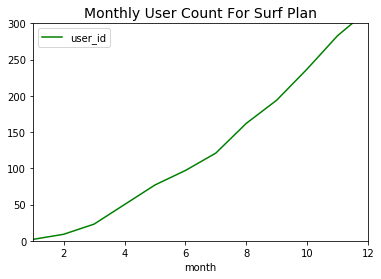

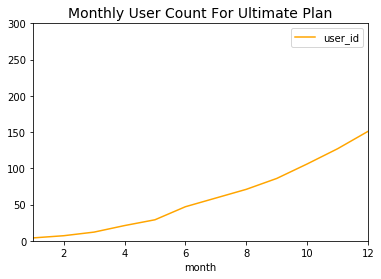

In [93]:
monthly_users.query('plan=="surf"').plot(x='month', y='user_id', color='green', ylim=(0,300));
plt.title('Monthly User Count For Surf Plan', fontsize=14);
monthly_users.query('plan=="ultimate"').plot(x='month', y='user_id', color='orange', ylim=(0,300));
plt.title('Monthly User Count For Ultimate Plan', fontsize=14);

##### We can see a definite rise for both plans, as we saw before the rise for surf plan is more steep

So, we can see that more and more people are joining both of the plans, when surf plan is a big winner in that criteria.
<br>when looking at the means per month for all parameter we can see that they rise throughout the year, so it doesn't matter that there are more people in the plan, all of the customers also consume more and more usage units (calls, sms and GB).
<br>we can see that the means go up for both plans, but for ultimate the revenue is pretty fixed on the monthly charge.

### Let's find the central tendency - the mean, dispersion and standard deviation:<a class="anchor" id="section_2_1">

#### [Go back to the Table of Contents](#table_of_contents)  

#### Surf Plan:

In [94]:
final_data.query('plan=="surf"')[['duration','sms_sent','GB_used','revenue']].describe()

,duration,sms_sent,GB_used,revenue
count,1573.000000,1573.000000,1573.000000,1573.000000
mean,428.749523,31.159568,16.670693,60.706408
std,234.453150,33.566717,7.847522,55.388042
min,0.000000,0.000000,0.000000,20.000000
25%,272.000000,3.000000,12.000000,20.000000
50%,425.000000,24.000000,17.000000,40.360000
75%,576.000000,47.000000,21.000000,80.360000
max,1510.000000,266.000000,70.000000,590.370000


In [95]:
display('Surf Plan Variance', final_data.query('plan=="surf"')[['duration','sms_sent','GB_used','revenue']].var())

'Surf Plan Variance'

duration    54968.279461
sms_sent     1126.724522
GB_used        61.583600
revenue      3067.835152
dtype: float64

### Ultimate Plan:

In [96]:
final_data.query('plan=="ultimate"')[['duration','sms_sent','GB_used','revenue']].describe()

,duration,sms_sent,GB_used,revenue
count,720.000000,720.000000,720.000000,720.000000
mean,430.450000,37.551389,17.306944,72.313889
std,240.508762,34.767179,7.670108,11.395108
min,0.000000,0.000000,0.000000,70.000000
25%,260.000000,7.000000,13.000000,70.000000
50%,424.000000,30.000000,17.000000,70.000000
75%,565.250000,61.000000,21.000000,70.000000
max,1369.000000,166.000000,46.000000,182.000000


In [97]:
display('Ultimate Plan Variance', final_data.query('plan=="ultimate"')[['duration','sms_sent','GB_used','revenue']].var())

'Ultimate Plan Variance'

duration    57844.464812
sms_sent     1208.756744
GB_used        58.830550
revenue       129.848486
dtype: float64

#### We can see the means for the usage is pretty similar for both plans.
#### The mean revenue for ultimate is 10 dollars, or 16% higher than the one of surf plan.
#### The variance don't seem very logical for me, but we will find out what that is all about. (I think it's because we have significant outliers)
#### We see the variance for all parameters but revenue is very similar and for revenue the variance of the surf plan is much higher, that makes sense, since the revenue vary greatly due to customer exceeding their limits.

In [98]:
#Slice the data by plan
final_surf = final_data.query('plan == "surf"')
final_ultimate = final_data.query('plan == "ultimate"')

#### Ploting graphs to describe distribution:

In [99]:
#building a pivot table with plan and month index and the sum of usage as values:
total_per_month = final_data.pivot_table(
    index=['plan','month'], 
    values=['duration', 'sms_sent', 'GB_used', 'revenue'], 
    aggfunc='sum').reset_index()

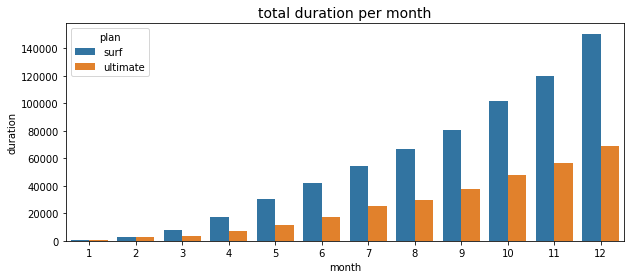

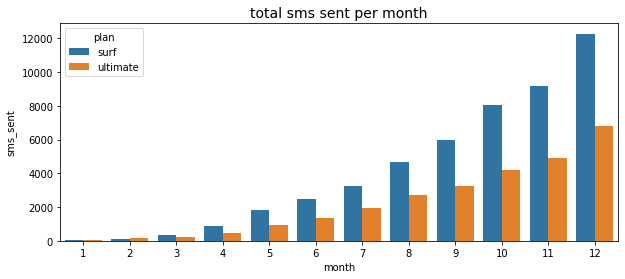

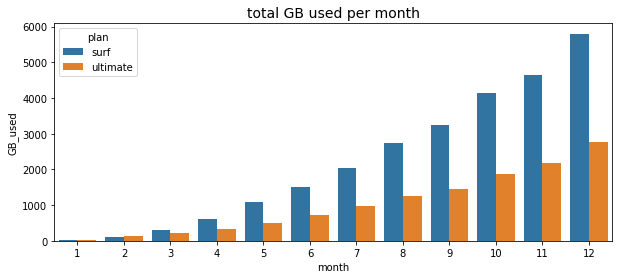

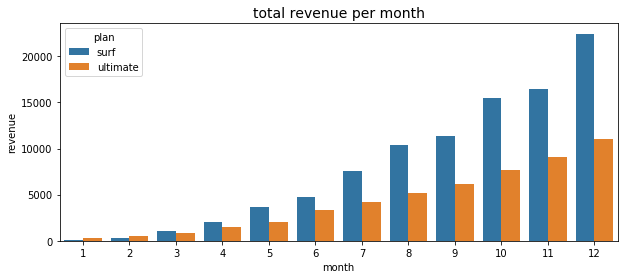

In [100]:
columns = ["duration","sms_sent","GB_used","revenue"]
for column in columns:
    fig, ax = plt.subplots(figsize=(10,4))
    x = sns.barplot(x = total_per_month.month, y = total_per_month[column], hue = total_per_month.plan)
    plt.title('total '+column.replace('_',' ')+' per month', fontsize=14)
    plt.show()   

##### We can see that both plan's parameter's distribution are similar, the surf plan has steepier rise throughout the year, but it is important to remember that we are using the sum of usage, so the number of customer affect the shape and differences greatly. let's see how the distribution looks for the mean of each month.

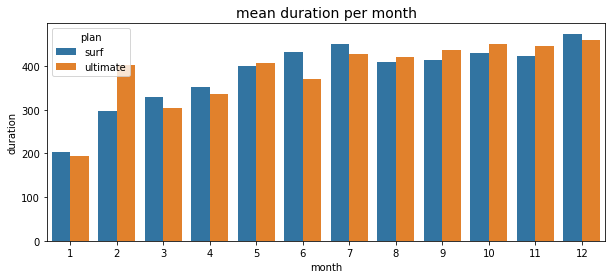

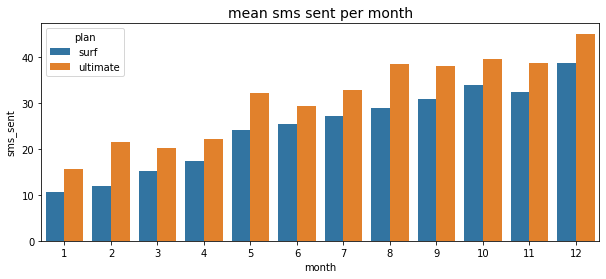

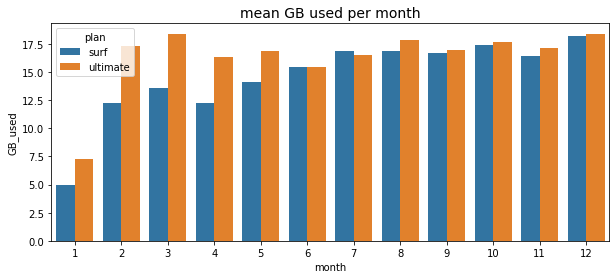

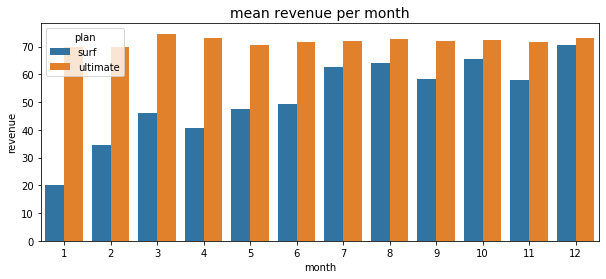

In [101]:
columns = ["duration","sms_sent","GB_used","revenue"]
for column in columns:
    fig, ax = plt.subplots(figsize=(10,4))
    x = sns.barplot(x = mean_per_month.month, y = mean_per_month[column], hue = mean_per_month.plan)
    plt.title('mean '+column.replace('_',' ')+' per month', fontsize=14)
    plt.show()   

##### It is much more clear now, that the surf plans usage vary more than the one of ultimate, as do the revenue.
##### The ultimate plan revenue stays the same throughout the year, wheras the  surf plan revenue grows each month, but alwys stays lower than the ultimate revenue.
##### To sum, i would say that the ultimate plan produce higher revenue than the surf plan. at this point i can suggest maybe increasing the extra usage fares for surf plan because we see that the surf users usually exceed the plans limits but still pay less than ultimate. 

### Let's plot some histogram to continue compare the plans:

In [2]:
columns=["duration","sms_sent","GB_used", 'revenue']

for x in columns:
    # Histogram for surf plan
    plt.hist(final_surf[x], color = 'purple', edgecolor = 'black', bins =12, alpha=0.8)        
    # Histogram for ultimate plan
    plt.hist(final_ultimate[x], color = 'orange', edgecolor = 'black', bins = 12, alpha=0.6)         
    # Add labels
    plt.title('Distribution of ' +x.replace('_', ' '),fontsize=14)
    plt.ylabel('Counts') 
    # Plot the histograms 
    plt.show()

NameError: name 'plt' is not defined

**We see that the parameters of usage acts similar for both plans.<br> Surf users actually use more units (higher calls duration, more sms, more GB used) than the unltimate plan. <br>The revenue vary for the surf and not vary at all for ultimate, as all of ultimate users pays 70 dollar give or take a couple of bucks.<br> as we stated before, the conclusion the company might want to get to is revise their surf fares to increase revenue from surf users, as they are also the bigger portion (if the data we got is a random sample of users).**

#### [Go back to the Table of Contents](#table_of_contents)  

### Test The Hypotheses: <a class="anchor" id="section_2_2">

#### Hypothesis no.1:
##### H0: The average revenue from users of Ultimate and Surf calling plans not differs.
##### H1: The average revenue from users of Ultimate and Surf calling plans differs.

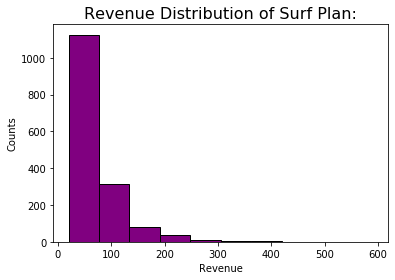

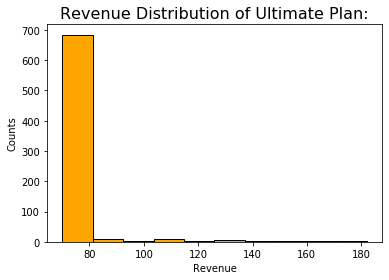

In [103]:
plt.hist(final_surf['revenue'],bins=10, color='purple', histtype='bar', edgecolor='black');
plt.title('Revenue Distribution of Surf Plan:', fontsize=16)
plt.ylabel('Counts')
plt.xlabel('Revenue')
plt.show()

plt.hist(final_ultimate['revenue'],bins=10, color='orange', histtype='bar', edgecolor='black');
plt.title('Revenue Distribution of Ultimate Plan:', fontsize=16)
plt.ylabel('Counts')
plt.xlabel('Revenue')
plt.show()

**The distribution we have is not normal, we have un-paired smaples. for that reason we will use the Mann-Whitney U test**

Mann-Whitney U test is the non-parametric alternative test to the independent sample t-test.  It is a non-parametric test that is used to compare two sample means that come from the same population, and used to test whether two sample means are equal or not.  Usually, the Mann-Whitney U test is used when the data is ordinal or when the assumptions of the t-test are not met.

In [104]:
# Define the two samples:
ultimate = final_ultimate['revenue']
surf = final_surf['revenue']

# compare samples
stat, p = mannwhitneyu(surf, ultimate)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution ( We cant reject the null hypothesis )')
else:
    print('Different distribution ( We reject the null hypothesis )')
alpha = 0.05

Statistics=355086.000, p=0.000
Different distribution ( We reject the null hypothesis )


**Well, there we go, just as suspected, the distribution differs between the two plans**
* We respectively reject the null hypothesis, therefore we accept the alternative

#### Hypothsis no.2:

##### H0 : The average revenue from users in NY-NJ area is **not** different from that of the users from other regions.
##### H1: The average revenue from users in NY-NJ area is different from that of the users from other regions.

first we will locate the users from NY-NJ area.

In [105]:
display(final_data['city'].value_counts())

New York-Newark-Jersey City, NY-NJ-PA MSA          377
Los Angeles-Long Beach-Anaheim, CA MSA             132
Chicago-Naperville-Elgin, IL-IN-WI MSA              94
Dallas-Fort Worth-Arlington, TX MSA                 88
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA     82
                                                  ... 
Omaha-Council Bluffs, NE-IA MSA                      3
Jacksonville, FL MSA                                 2
Raleigh-Cary, NC MSA                                 2
El Paso, TX MSA                                      2
Cape Coral-Fort Myers, FL MSA                        1
Name: city, Length: 73, dtype: int64

In [106]:
#slicing the data to the two samples we have
NY_NJ = ['New York', 'Jersey City']
NY_NJ_users = final_data.loc[final_data['city'].str.contains("New York|Jersey|Philadelphia", case=False)].reset_index()
rest_users = final_data.loc[~final_data['city'].str.contains("New York|Jersey|Philadelphia")].reset_index()

In [107]:
NY_NJ_users['city'].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          377
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA     82
Name: city, dtype: int64

In [108]:
rest_users['city'].value_counts()

Los Angeles-Long Beach-Anaheim, CA MSA              132
Chicago-Naperville-Elgin, IL-IN-WI MSA               94
Dallas-Fort Worth-Arlington, TX MSA                  88
Boston-Cambridge-Newton, MA-NH MSA                   70
Washington-Arlington-Alexandria, DC-VA-MD-WV MSA     62
                                                   ... 
Omaha-Council Bluffs, NE-IA MSA                       3
Jacksonville, FL MSA                                  2
Raleigh-Cary, NC MSA                                  2
El Paso, TX MSA                                       2
Cape Coral-Fort Myers, FL MSA                         1
Name: city, Length: 71, dtype: int64

In [109]:
NY_NJ_users['revenue'].describe()

count    459.000000
mean      60.580196
std       45.111623
min       20.000000
25%       20.000000
50%       52.550000
75%       70.570000
max      280.000000
Name: revenue, dtype: float64

In [110]:
rest_users['revenue'].describe()

count    1834.000000
mean       65.294913
std        46.960700
min        20.000000
25%        26.442500
50%        70.000000
75%        70.000000
max       590.370000
Name: revenue, dtype: float64

**We have our smaples, let plot some graphs to help us decide which test to use**

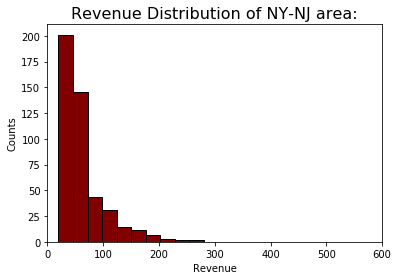

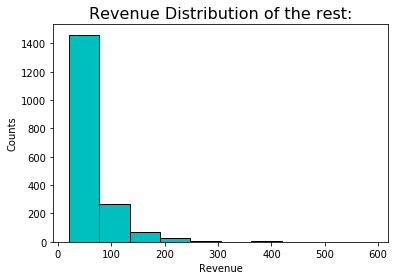

In [111]:
plt.hist(NY_NJ_users['revenue'],bins=10, color='maroon', edgecolor='black');
plt.title('Revenue Distribution of NY-NJ area:', fontsize=16)
plt.xlim(0,600)
plt.ylabel('Counts')
plt.xlabel('Revenue')
plt.show()

plt.hist(rest_users['revenue'],bins=10, color='c', edgecolor='black');
plt.title('Revenue Distribution of the rest:', fontsize=16)
plt.ylabel('Counts')
plt.xlabel('Revenue')
plt.show()

**Again we have distribution that is not normal, we will use the Mann Whitney U test**

In [112]:
# Define the two samples:
NY_NJ = NY_NJ_users['revenue']
rest = rest_users['revenue']

# compare samples
stat, p = mannwhitneyu(NY_NJ, rest)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution ( We cant reject the null hypothesis )')
else:
    print('Different distribution ( We reject the null hypothesis )')
alpha = 0.05

Statistics=379583.500, p=0.000
Different distribution ( We reject the null hypothesis )


**What we saw in the graph is now a fact - The distributions are not the same**
* **We reject the null hypothesis**

we can understand by the graphs that the majority in NY-NJ area are in the surf plan. let's have a check before moving to final conclusions.

In [113]:
display('The portion of surf plan in NY-NJ area users: ',len(NY_NJ_users.query('plan=="surf"'))/len(NY_NJ_users))
display('The portion of surf plan in the rest area users: ',len(rest_users.query('plan=="surf"'))/len(rest_users))

'The portion of surf plan in NY-NJ area users: '

0.7886710239651417

'The portion of surf plan in the rest area users: '

0.6603053435114504

We were not wrong-
* The portion of surf plan in the NY-NJ area users is 78% 
* in the rest of the areas that portion is 64%.

#### [Go back to the Table of Contents](#table_of_contents)  

### Overall Conclusion: <a class="anchor" id="chapter3">

* We started with 5 different data sets that contained different information about the same customers.
* We then prepared the data, identified errors in the data, dealt with missing values and converted dtypes.
* We moved on to constructing some new columns such as month of usage, then we combined the relevant data.
* After calculating revenue per user and users per months we started analyzing the data and here is the final conclusion:
 * surf users use more units of usage than ultimate even though their limit is lower.
 * the ultimate plan users brings in more revenue than the surf.
 * both of the above leads to the suggestion to revise the fare for surf plan, i believe that if the users will pay a bit more for extra usage they will bring more revenue to the company.
 * We can see that when checking the NY-NJ area in relation to the rest of the areas, the revenue was lower, and our hypothsis that the majority of NY-NJ area users are in the surf was correct, only supporting the clame above.
 
**Bottom line is, ultimate plan brings in more revenue**
the usage is similar for both plan but surf pays a lot less than ultimate.